Import Requirements

In [1]:
import os
import random

import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

Set the Hyperparameters

In [2]:
model_name = "efficientnet_b0"
weights = None #"imagenet"
input_dims = (128, 128, 3)
num_classes = 101
epochs = 250
batch_size = 256
shuffle_size = 16
learning_rate = 0.01
precision = "mixed_float16" #"float32"
model_dir = "models"
testing_set = 0.15

In [3]:
policy = tf.keras.mixed_precision.Policy(precision)
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


Create the EfficientNet Model

In [4]:
dropout = 0.2
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

In [5]:
models = {
    'efficientnet_b0': tf.keras.applications.EfficientNetB0,
    'efficientnet_b1': tf.keras.applications.EfficientNetB1,
    'efficientnet_b2': tf.keras.applications.EfficientNetB2,
    'efficientnet_b3': tf.keras.applications.EfficientNetB3,
    'efficientnet_b4': tf.keras.applications.EfficientNetB4,
    'efficientnet_b5': tf.keras.applications.EfficientNetB5,
    'efficientnet_b6': tf.keras.applications.EfficientNetB6,
    'efficientnet_b7': tf.keras.applications.EfficientNetB7
}
inputs = tf.keras.Input(shape=input_dims)
backbone = models[model_name](include_top=False,
                              weights=weights,
                              input_shape=input_dims,
                              classes=num_classes)(inputs)
backbone.trainable = True
# Output Arch
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(backbone)
x = tf.keras.layers.Dropout(dropout, name='top_dropout')(x)
output = tf.keras.layers.Dense(
    num_classes,
    activation="softmax",
    kernel_initializer=DENSE_KERNEL_INITIALIZER,
    name="predictions",
    dtype="float32")(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name=model_name)

In [6]:
model.summary()

Model: "efficientnet_b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 predictions (Dense)         (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
____________________________________

Import training data (CIFAR-10)

In [7]:
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
"""

'\n(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()\nprint(x_train.shape)\nprint(y_train.shape)\n'

Import Real Training Data

In [8]:
x_train = []
y_train = []
labels_list = []

labels = os.listdir("data")
label_cn = 0
for label in labels:
    images_in_labels = os.listdir("data/" + label)
    for image in images_in_labels:
        labels_list.append(image)
        sub_images = os.path.join("data", label, image)
        for _t in os.listdir(sub_images):
            try:
                if _t.endswith(".jpg") or _t.endswith(".png") or _t.endswith(".jpeg"):
                    im = np.array(
                            cv2.imread(
                                os.path.join(sub_images, _t)))
                    if len(im.shape) == 3:
                        x_train.append(im)
                        y_train.append(int(label))
            except:
                pass
    label_cn += 1

Preprocessing

In [9]:
def augment_preprocess(image):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_dims[0], input_dims[1]))
    return image

def one_hot(indicies):
    return tf.one_hot(indicies, num_classes)[0]

In [10]:
# Load the data into RAM for extremely fast training
x_list = [augment_preprocess(image) for image in x_train]
y_list = [one_hot([label]) for label in y_train]

combined = list(zip(x_list, y_list))
random.shuffle(combined)
x_list, y_list = zip(*combined)

x_list = list(x_list)
y_list = list(y_list)

In [11]:
test_split = int(len(x_list) * (1-testing_set))

x_training = np.array(x_list[:test_split])
y_training = np.array(y_list[:test_split])

x_testing = np.array(x_list[test_split:len(x_list)])
y_testing = np.array(y_list[test_split:len(x_list)])

In [12]:
print(test_split)
print(len(x_training))

10934
10934


In [13]:
print("Training image shapes " + str(x_training.shape))
print("Training label shapes " + str(y_training.shape))

print("Testing image shapes " + str(x_testing.shape))

print("Training set size " + str(len(x_training)))

Training image shapes (10934, 128, 128, 3)
Training label shapes (10934, 101)
Testing image shapes (1930, 128, 128, 3)
Training set size 10934


Datagenerator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.3, 1.0])  # brightness

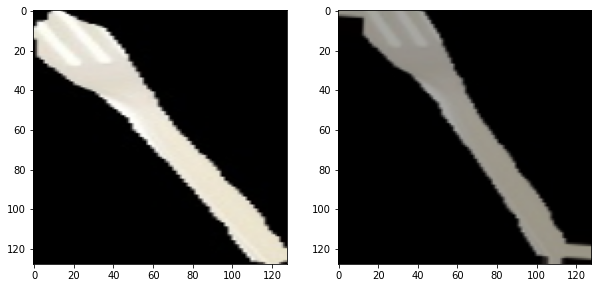

In [16]:
# View the original and augmented images
image = x_training[2229]
aug_image = train_datagen.random_transform(image)/255
figure = plt.figure(figsize=(10, 10))
figure.add_subplot(1, 2, 1)
plt.imshow(image)
figure.add_subplot(1, 2, 2)
plt.imshow(aug_image)
plt.show()

Training Settings

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [18]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(model_dir, model_name, "tensorboard"),
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)
learning_rate_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

Training

In [19]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=["accuracy", "categorical_crossentropy"])
model.fit(train_datagen.flow(x_training, y_training, batch_size=batch_size), epochs=epochs, shuffle=True, callbacks=[tensorboard_cb, learning_rate_cb], validation_data=(x_testing, y_testing))

Epoch 1/250
43/43 [==============================] - 57s 847ms/step - loss: 4.7171 - accuracy: 0.0509 - categorical_crossentropy: 4.7171 - val_loss: 4.7459 - val_accuracy: 0.0611 - val_categorical_crossentropy: 4.7459 - lr: 0.0100
Epoch 2/250
43/43 [==============================] - 33s 754ms/step - loss: 4.1514 - accuracy: 0.0772 - categorical_crossentropy: 4.1514 - val_loss: nan - val_accuracy: 0.0606 - val_categorical_crossentropy: nan - lr: 0.0100
Epoch 3/250
43/43 [==============================] - 33s 763ms/step - loss: 3.9468 - accuracy: 0.0991 - categorical_crossentropy: 3.9468 - val_loss: 5.2000 - val_accuracy: 0.0637 - val_categorical_crossentropy: 5.2000 - lr: 0.0100
Epoch 4/250
43/43 [==============================] - 33s 755ms/step - loss: 3.7990 - accuracy: 0.1182 - categorical_crossentropy: 3.7990 - val_loss: 4.5380 - val_accuracy: 0.0466 - val_categorical_crossentropy: 4.5380 - lr: 0.0100
Epoch 5/250
43/43 [==============================] - 34s 780ms/step - loss: 3.6842

In [20]:
tf.keras.models.save_model(model, os.path.join(model_dir, model_name, "model_final_extradata_101_recycling_fp32"))

INFO:tensorflow:Assets written to: models\efficientnet_b0\model_final_extradata_101_recycling_fp32\assets


INFO:tensorflow:Assets written to: models\efficientnet_b0\model_final_extradata_101_recycling_fp32\assets


Testing

In [21]:
model.evaluate(x_testing, y_testing, batch_size=batch_size)

8/8 [==============================] - 2s 279ms/step - loss: 1.9532 - accuracy: 0.5845 - categorical_crossentropy: 1.9532


[1.9531731605529785, 0.5844559669494629, 1.9531731605529785]

Visual Testing

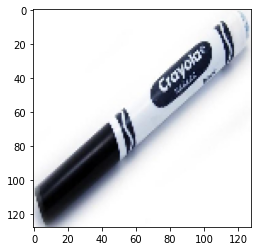

nonWovenBag


In [22]:
test_index = 336
plt.imshow(x_training[test_index])
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(x_training[test_index], axis=0), training=False), axis=0))
prediction = labels_list[pred_index-1]
print(prediction)

In [23]:
print(labels_list)

['plasticBag', 'dirtyBag', 'helmet', 'plasticCup', 'paperCup', 'styroCup', 'paperBento', 'receipt', 'chipBag', 'rubberBand', 'chipCan', 'pizzaBox', 'rainCoat', 'porcelain', 'portablePaperBag', 'comb', 'soapDispenser', 'mask', 'trashBag', 'rawKitchenWaste', 'cookedFoodWaste', 'plasticSpoon', 'eggCarton', 'pen', 'plushToy', 'facialCleanser', 'productPackaging', 'onionBag', 'chargingCable', 'pottedPlants', 'yakult', 'advertisingFlyer', 'transparentContainer', 'wood', 'lunchTray', 'creamers', 'cigaretteCase', 'yogaMat', 'toiletBrush', 'paperDiapers', 'fruitNet', 'milkCarton', 'disposableChopsticks', 'waterFilter', 'headphones', 'phoneCase', 'yogurtCup', 'mirror', 'bubbleWrap', 'litter', 'lipstick', 'shreddedPaper', 'shoe', 'foamPeanuts', 'coatHanger', 'pencil', 'newspaper', 'hotCoffeeCup', 'boosterPack', 'spoutBag', 'snackPaperBag', 'aluminumFoil', 'quiltPillow', 'plasticStraw', 'wasteMedicine', 'instantNoodleBowl', 'glassBottle', 'whiteout', 'toy', 'staple', 'capsuleCoffee', 'coffeePod', 